# Conditionnal Generative Adversarial Network (CGAN)

In [1]:
import keras
from keras import layers
from keras.datasets import mnist
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

2022-11-27 15:28:47.132292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 15:28:47.953234: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-27 15:28:47.953306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-27 15:28:47.953315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
input_vector_size=128
# Partie pour pouvoir générer un nombre spécifique
input = layers.Input(shape=(1,))
x = layers.Embedding(10,50)(input)
x = layers.Dense(49)(x)
x = layers.Reshape((7,7,1))(x)
# Partie pour générer aléatoirement un digit
input2 = layers.Input(shape=(input_vector_size,))
x2 = layers.Dense(1568)(input2)
x2 = layers.Reshape((7,7,32))(x2)
# Partie commune du générateur
x3 = layers.Concatenate()([x,x2])
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2DTranspose(128, kernel_size=(3,3), strides=2, padding="same", activation='relu')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2DTranspose(128, kernel_size=(3,3), strides=2, padding="same", activation='relu')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2DTranspose(1, kernel_size=(3,3), strides=1, padding="same", activation='relu')(x3)

generator = keras.Model([input,input2], x3)

generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 1, 49)        2499        ['embedding[0][0]']              
                                                                                              

2022-11-27 15:28:49.519483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 15:28:49.551227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-27 15:28:49.551247: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-27 15:28:49.551617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [3]:
# Partie permettant l'insertion de la condition, ici notre label
input = layers.Input(shape = (1,))
x = layers.Embedding(10,50)(input)
x = layers.Dense(28*28)(x)
x = layers.Reshape((28,28,1))(x)

# Partie pour discriminer une image
input2 = layers.Input(shape=(28,28,1))

x3 = layers.Concatenate()([x,input2])
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x3)
x3 = layers.MaxPooling2D()(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x3)
x3 = layers.MaxPooling2D()(x3)
x3 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x3)
x3 = layers.MaxPooling2D()(x3)
x3 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(x3)
x3 = layers.MaxPooling2D()(x3)
x3 = layers.Flatten()(x3)
x3 = layers.Dense(1, activation='sigmoid')(x3)

discriminator = keras.Model([input,input2],x3)

discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 1, 784)       39984       ['embedding_1[0][0]']            
                                                                                                  
 reshape_2 (Reshape)            (None, 28, 28, 1)    0           ['dense_2[0][0]']                
                                                                                            

In [4]:
generator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

In [5]:

input_class=  layers.Input(shape=(1,))
input_noise = layers.Input(shape=(input_vector_size,))

discriminator.trainable=False
image = generator([input_class, input_noise])
valid = discriminator([input_class,image])

combined_network = keras.Model([input_class,input_noise], valid)
combined_network.compile(loss='binary_crossentropy',optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])



In [6]:
def display_images():
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,input_vector_size))
        random_y = []

        for i in range(r*c):
            random_y.append(i%10)

        generated_images = generator.predict([np.array(random_y),noise])

        #Scaling the generated images
        generated_images = 0.5 * generated_images + 0.5

        fig, axs = plt.subplots(r, c)
        count = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generated_images[count, :,:,])
                axs[i,j].axis('off')
                count += 1
        plt.show()
        plt.close()

1/1 [==============================] - 0s 29ms/step
EPOCH ===  0
Generator loss =  [0.8038095235824585, 0.0]
Discriminator_loss =  0.004458589944988489
1/1 [==============================] - 0s 122ms/step


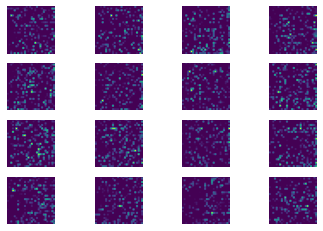

1/1 [==============================] - 0s 32ms/step
EPOCH ===  10
Generator loss =  [3.6764345169067383, 0.0]
Discriminator_loss =  2.3274140403373167e-05
1/1 [==============================] - 0s 45ms/step


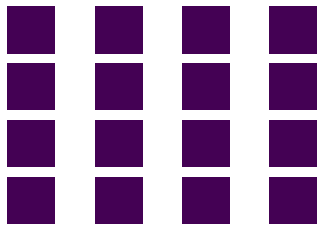

1/1 [==============================] - 0s 29ms/step
EPOCH ===  20
Generator loss =  [0.23691600561141968, 0.90625]
Discriminator_loss =  9.853823576122522e-05
1/1 [==============================] - 0s 24ms/step


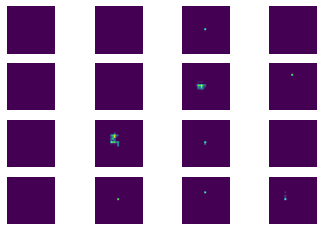

1/1 [==============================] - 0s 32ms/step
EPOCH ===  30
Generator loss =  [0.004648297093808651, 1.0]
Discriminator_loss =  1.1337493560859002e-05
1/1 [==============================] - 0s 24ms/step


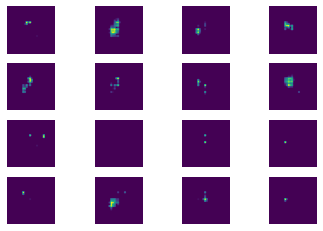

1/1 [==============================] - 0s 29ms/step
EPOCH ===  40
Generator loss =  [0.03110203519463539, 1.0]
Discriminator_loss =  0.0003418878186494112
1/1 [==============================] - 0s 25ms/step


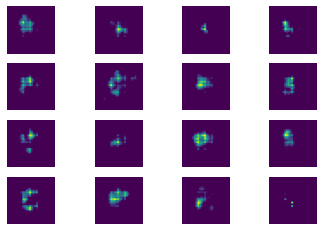

1/1 [==============================] - 0s 30ms/step
EPOCH ===  50
Generator loss =  [9.252309799194336, 0.0]
Discriminator_loss =  0.003311365144327283
1/1 [==============================] - 0s 26ms/step


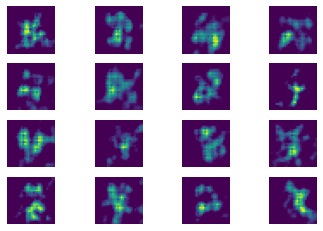

1/1 [==============================] - 0s 37ms/step
EPOCH ===  60
Generator loss =  [13.153768539428711, 0.0]
Discriminator_loss =  0.0005365090328268707
1/1 [==============================] - 0s 23ms/step


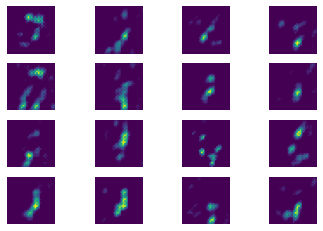

1/1 [==============================] - 0s 30ms/step


KeyboardInterrupt: 

In [7]:
num_epochs = 10000
batch_size = 32

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size,1))

display_interval = 10
for epoch in range(num_epochs):


    discm_loss_real = 0
    discm_loss_fake = 0
    genr_loss = 0
    for i in range(np.random.randint(1,10)):
        # On choisit aléatoirement des données
        index = np.random.randint(0, x_train.shape[0], batch_size)
        images = x_train[index]
        label_images = y_train[index]
        # On entraine sur le vrai dataset

        # On entraine sur des données générées
        random_y = np.random.randint(0,10,batch_size)
        noise = np.random.normal(0,1,(batch_size, input_vector_size))
        #On génère une image aléatoire, avec une classe aléatoirement choisie
        generated_images = generator.predict([random_y,noise])
        for i in range(0,10):
            discm_loss_real = discriminator.train_on_batch([label_images,images], valid)
            discm_loss_fake = discriminator.train_on_batch([random_y, generated_images], fake)

        genr_loss=combined_network.train_on_batch([random_y, noise], valid)



    if epoch % display_interval == 0:
        print("EPOCH === ", epoch)
        print('Generator loss = ', genr_loss)
        print('Discriminator_loss = ', discm_loss_fake)
        display_images()


In [ ]:
noise = np.random.normal(0,1,(1, input_vector_size))
image = generator.predict([
    np.array([2]),
    noise
])

plt.imshow(image[0, :,:,])
plt.axis('off')